<a href="https://colab.research.google.com/github/RajatRasal/Gaussian-Process-Dynamical-Model/blob/main/experiments/Gaussian_Process_Latent_Variable_Model_for_Dynamical_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

# Gaussian Process Latent Variable Models

## Imports

In [1]:
!git clone https://github.com/RajatRasal/Gaussian-Process-Dynamical-Model.git

Cloning into 'Gaussian-Process-Dynamical-Model'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 5), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [2]:
!pip install transforms3d

     |████████████████████████████████| 62 kB 1.1 MB/s 
  Created wheel for transforms3d: filename=transforms3d-0.3.1-py3-none-any.whl size=59373 sha256=1196f3eec30005b39bb36a9d7423b8e2e7b7a02a95b1a6072f317991b8947cac
  Stored in directory: /root/.cache/pip/wheels/b5/b7/93/8985551f83720ce37548a5b543c75380bb707955a9c2c5d28c
Successfully built transforms3d


In [24]:
import sys
sys.path.append('Gaussian-Process-Dynamical-Model')

import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
from sklearn.decomposition import PCA
%pylab inline

from dataloader import amc_to_matrix

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
np_precision = np.float32

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load MNIST Data

In [25]:
!wget http://mocap.cs.cmu.edu/subjects/07/07_02.amc

--2022-04-18 09:47:40--  http://mocap.cs.cmu.edu/subjects/07/07_02.amc
Resolving mocap.cs.cmu.edu (mocap.cs.cmu.edu)... 128.2.220.105
Connecting to mocap.cs.cmu.edu (mocap.cs.cmu.edu)|128.2.220.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263117 (257K)
Saving to: ‘07_02.amc.1’

07_02.amc.1         100%[===================>] 256.95K   169KB/s    in 1.5s    

2022-04-18 09:47:43 (169 KB/s) - ‘07_02.amc.1’ saved [263117/263117]



In [26]:
x = amc_to_matrix('./07_02.amc')
small_x_train = np.array(x, dtype=np_precision)
small_x_train -= small_x_train.mean(axis=0)
N = small_x_train.shape[0]
dim = small_x_train.shape[1]

In [27]:
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

## Prepare trainable variables
We'll be jointly training 3 model parameters as well as the latent inputs.

In [141]:
# Create a collection of N 2-dimensional index points that will represent our
# latent embeddings of the data. (Lawrence, 2004) prescribes initializing these
# with PCA, but a random initialization actually gives not-too-bad results, so
# we use this for simplicity. For a fun exercise, try doing the
# PCA-initialization yourself!
def init_latents(dims=3, _type='pca', name='latent_index_points', seed=seed):
    if _type == 'random':
        init_ = np.random.normal(size=(N, dims), seed=seed) \
            .astype(dtype=np_precision)
    elif _type == 'pca':
        init_ = PCA(n_components=dims) \
            .fit_transform(small_x_train) \
            .astype(dtype=np_precision)
    latent_index_points = tf.Variable(init_, name=name)
    return init_, latent_index_points

# Create some trainable model parameters. We will constrain them to be strictly
# positive when constructing the kernel and the GP.
unconstrained_amplitude = tf.Variable(np_precision(1.), name='amplitude')
unconstrained_length_scale = tf.Variable(np_precision(1.), name='length_scale')
unconstrained_slope_variance = tf.Variable(np_precision(1.), name='slope_variance')
unconstrained_scale_diag = tf.Variable(
    np.ones((dim, 1)).astype(dtype=np_precision),
    name='scale_diag'
)
unconstrained_scale_diag2 = tf.Variable(
    np.ones((dim, 1)).astype(dtype=np_precision),
    name='scale_diag2'
)
unconstrained_observation_noise_var = tf.Variable(
    np.random.normal(size=(dim, 1)).astype(dtype=np_precision),
    name='obs_noise',
)

latent_dim = 3
init_, latent_index_points = init_latents(dims=latent_dim)

# We need to flatten the images and, somewhat unintuitively, transpose from
# shape [100, 784] to [784, 100]. This is because the 784 pixels will be
# treated as *independent* conditioned on the latent inputs, meaning we really
# have a batch of 784 GP's with 100 index_points.
observations_ = small_x_train.reshape(N, -1).transpose()

## Construct model and training ops

In [142]:
def constrain_positive(unconstrained_var):
    EPS = np.finfo(np_precision).eps
    return tf.math.softplus(EPS + unconstrained_var)

def rbf_kernel(
    unconstrained_amplitude,
    unconstrained_length_scale,
    unconstrained_scale_diag=None
):
    amplitude = constrain_positive(unconstrained_amplitude)
    length_scale = constrain_positive(unconstrained_length_scale)
    _rbf_kernel = tfk.ExponentiatedQuadratic(
        amplitude,
        length_scale,
        validate_args=True
    )
    if unconstrained_scale_diag is not None:
        _rbf_kernel = tfk.FeatureScaled(
            _rbf_kernel,
            inverse_scale_diag=unconstrained_scale_diag,
            validate_args=True
        )
    return _rbf_kernel

def linear_kernel(
    unconstrained_slope_variance,
    unconstrained_scale_diag2,
):
    _linear_kernel = tfk.Linear(slope_variance=unconstrained_slope_variance)
    if unconstrained_scale_diag2 is not None:
        _linear_kernel = tfk.FeatureScaled(
            _linear_kernel,
            inverse_scale_diag=unconstrained_scale_diag2,
            validate_args=True
        )
    return _linear_kernel

def linear_rbf_kernel(
    unconstrained_amplitude,
    unconstrained_length_scale,
    unconstrained_slope_variance,
    unconstrained_scale_diag=None,
    unconstrained_scale_diag2=None,
):
    _rbf_kernel = rbf_kernel(
        unconstrained_amplitude,
        unconstrained_length_scale,
        unconstrained_scale_diag,
    )
    _linear_kernel = linear_kernel(
        unconstrained_slope_variance,
        unconstrained_scale_diag2,  
    )
    return _rbf_kernel + _linear_kernel

def build_gp(**gp_params):
    return tfd.GaussianProcessRegressionModel(**gp_params)

def loss_fn(
    obs,
    latent_index_points,
    unconstrained_amplitude,
    unconstrained_length_scale,
    unconstrained_slope_variance,
    unconstrained_observation_noise_var,
    unconstrained_scale_diag=None,
    unconstrained_scale_diag2=None,
):
    observation_noise_variance = constrain_positive(
        unconstrained_observation_noise_var
    )
    kernel = linear_rbf_kernel(
        unconstrained_amplitude,
        unconstrained_length_scale,
        unconstrained_slope_variance,
        unconstrained_scale_diag,
        unconstrained_scale_diag2,
    )
    gp = build_gp(
        kernel=kernel,
        index_points=latent_index_points,
        observation_noise_variance=observation_noise_variance,
    )
    log_probs = gp.log_prob(obs, name='log_prob')
    loss = -tf.reduce_mean(log_probs)
    return loss

LR = 0.1
optimizer = tf.optimizers.Adam(learning_rate=LR)

@tf.function(autograph=False, jit_compile=True)
def train_model():
    trainable_variables = [
        latent_index_points,
        unconstrained_amplitude,
        unconstrained_length_scale,
        unconstrained_slope_variance,
        unconstrained_observation_noise_var,
        unconstrained_scale_diag,
        unconstrained_scale_diag2,
    ]
    with tf.GradientTape() as tape:
        loss_value = loss_fn(observations_, *trainable_variables)
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss_value

## Train and plot the resulting latent embeddings

In [143]:
# Initialize variables and train!
num_iters = 100
log_interval = 10
for i in range(num_iters):
    loss = train_model()
    if i % log_interval == 0 or i + 1 == num_iters:
        print("Loss at step %d: %f" % (i, loss))

Loss at step 0: 1343.820557
Loss at step 10: 847.566528
Loss at step 20: 535.236389
Loss at step 30: 455.075928
Loss at step 40: 368.833344
Loss at step 50: 290.035004
Loss at step 60: 226.175766
Loss at step 70: 176.127151
Loss at step 80: 139.916473
Loss at step 90: 116.818604
Loss at step 99: 103.562767


## Plot results

In [144]:
def plotting_latent_2d(before, after):
    plt.figure(figsize=(7, 7))
    plt.title("Before training")
    plt.grid(False)
    plt.scatter(
        x=before[:, 0],
        y=before[:, 1],
        color='green',
        s=50
    )
    plt.show()

    plt.figure(figsize=(7, 7))
    plt.title("After training")
    plt.grid(False)
    plt.scatter(
        x=after[:, 0],
        y=after[:, 1],
        color='blue',
        s=50
    )
    plt.show()

def plotting_latent_3d(before, after, x=None, y=None):
    plt.figure(figsize=(7, 7))
    ax = plt.axes(projection='3d')
    ax.view_init(x, y)
    ax.set_title("Before training")
    ax.scatter3D(
        before[:, 0],
        before[:, 1],
        before[:, 2],
        color='green',
        # s=50
    )
    plt.show()
    
    plt.figure(figsize=(7, 7))
    ax = plt.axes(projection='3d')
    ax.view_init(x, y)
    ax.set_title("After training")
    ax.scatter3D(
        after[:, 0],
        after[:, 1],
        after[:, 2],
        color='blue',
        # s=50
    )
    plt.show()

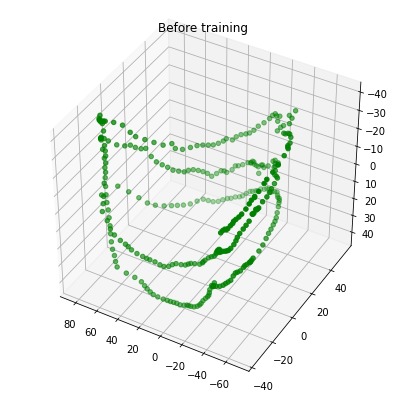

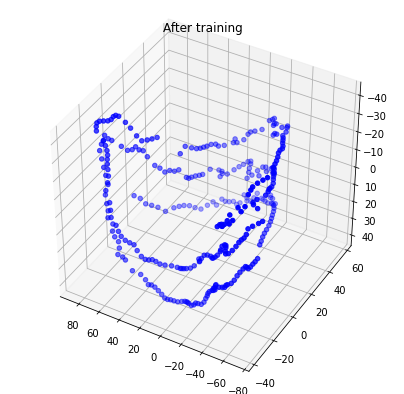

In [146]:
# Plot the latent locations before and after training
seq_len = 360
if latent_dims == 2:
    plotting_latent_2d(init_[:seq_len], latent_index_points.numpy()[:seq_len])
elif latent_dims == 3:
    plotting_latent_3d(init_[:seq_len], latent_index_points.numpy()[:seq_len], x=-140, y=60)
else:
    pass

## Construct predictive model and sampling ops

In [ ]:
gprm = build_gp(
    kernel=kernel,
    index_points=latent_index_points,
    observation_index_points=latent_index_points,
    observations=observations_,
)

samples = gprm.sample()

# Plot the grid of samples at new points. We do a bit of tweaking of the samples
# first, squeezing off extra 1-shapes and normalizing the values.

# Dynamical Loss Function

In [52]:
unconstrained_amplitude_dyn = tf.Variable(np_precision(1.), name='amplitude_dyn')
unconstrained_length_scale_dyn = tf.Variable(np_precision(1.), name='length_scale_dyn')
unconstrained_slope_variance_dyn = tf.Variable(np_precision(1.), name='slope_variance_dyn')

unconstrained_amplitude_obs = tf.Variable(np_precision(1.), name='amplitude_obs')
unconstrained_length_scale_obs = tf.Variable(np_precision(1.), name='length_scale_obs')
unconstrained_noise_var_obs = tf.Variable(
    np.random.normal(size=(dim, 1)).astype(dtype=np_precision),
    name='noise_var_obs',
)

dyn_latent_index_points = init_latents()

In [53]:
def dynamical_loss_fn(
    # Data
    obs,
    latent_index_points,
    # Dynamic Model Hyperparams
    unconstrained_amplitude_dyn,
    unconstrained_length_scale_dyn,
    unconstrained_slope_variance_dyn,
    # Obs Model Hyperparams
    unconstrained_amplitude_obs,
    unconstrained_length_scale_obs,
    unconstrained_noise_var_obs,
):
    # Dynamic Model
    dyn_kernel = linear_rbf_kernel(
        unconstrained_amplitude_dyn,
        unconstrained_length_scale_dyn,
        unconstrained_slope_variance_dyn,
    )
    dyn_kernel_matrix = dyn_kernel.matrix(
        latent_index_points,
        latent_index_points,
    )
    latent_dim = float(latent_index_points.shape[1])
    dyn_loss = latent_dim * 0.5 * tf.linalg.slogdet(dyn_kernel_matrix)[1] + \
        0.5 * tf.linalg.trace(tf.linalg.inv(dyn_kernel_matrix) @ latent_index_points @ tf.transpose(latent_index_points)) + \
        tf.math.log(constrain_positive(unconstrained_amplitude_dyn)) + \
        tf.math.log(constrain_positive(unconstrained_length_scale_dyn)) + \
        tf.math.log(constrain_positive(unconstrained_slope_variance_dyn))

    # Observational GP
    noise_var_obs = constrain_positive(
        unconstrained_noise_var_obs
    )
    obs_kernel = rbf_kernel(
        unconstrained_amplitude_obs,
        unconstrained_length_scale_obs,
    )
    gp = build_gp(
        kernel=obs_kernel,
        index_points=latent_index_points,
        observation_noise_variance=noise_var_obs,
    )

    # Obs Loss
    log_probs = gp.log_prob(obs, name='log_prob')
    obs_loss = tf.reduce_mean(log_probs)

    return -(obs_loss + dyn_loss)

LR = 0.1
optimizer = tf.optimizers.Adam(learning_rate=LR)

@tf.function()  # autograph=False, jit_compile=True)
def train_full_model():
    trainable_variables = [
        dyn_latent_index_points,
        unconstrained_amplitude_dyn,
        unconstrained_length_scale_dyn,
        unconstrained_slope_variance_dyn,
        unconstrained_amplitude_obs,
        unconstrained_length_scale_obs,
        unconstrained_noise_var_obs,
    ]
    with tf.GradientTape() as tape:
        loss_value = dynamical_loss_fn(observations_, *trainable_variables)
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss_value

In [56]:
num_iters = 2000
log_interval = 100
for i in range(num_iters):
    loss = train_full_model()
    if i % log_interval == 0 or i + 1 == num_iters:
        print("Loss at step %d: %f" % (i, loss))

Loss at step 0: -2217.571147
Loss at step 100: -2489.131651
Loss at step 200: -2693.438708
Loss at step 300: -2855.182512
Loss at step 400: -2994.700575
Loss at step 500: -3109.877857
Loss at step 600: -3211.401059
Loss at step 700: -3301.351089
Loss at step 800: -3383.815470
Loss at step 900: -3459.834154
Loss at step 1000: -3529.089496
Loss at step 1100: -3593.993688
Loss at step 1200: -3655.925757
Loss at step 1300: -3713.409905
Loss at step 1400: -3767.451575


KeyboardInterrupt: ignored

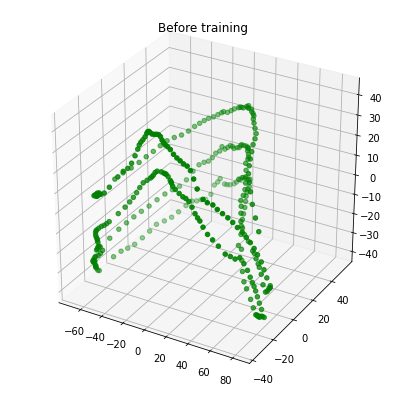

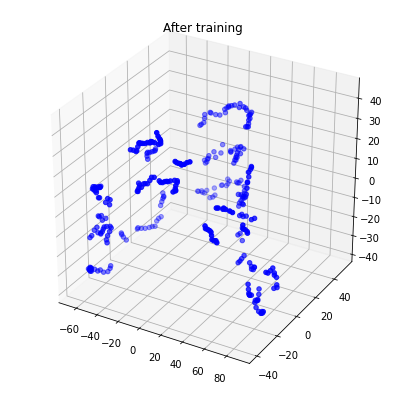

In [57]:
init__ = init_latents(_type='pca')
plotting_latent_3d(init__, dyn_latent_index_points.numpy())